In [1]:
from glob import glob

filenames = glob('scenes/*.jpg') #importing file names
print(filenames[:10])

['scenes/coast_n672003.jpg', 'scenes/opencountry_cdmc109.jpg', 'scenes/highway_gre474.jpg', 'scenes/forest_natu169.jpg', 'scenes/opencountry_land406.jpg', 'scenes/opencountry_nat1122.jpg', 'scenes/street_art379.jpg', 'scenes/opencountry_nat718.jpg', 'scenes/mountain_land879.jpg', 'scenes/tallbuilding_art1725.jpg']


In [2]:
#get class name from file name

classes = list(map(lambda x: x.split('/')[1].split('_')[0], filenames))
print(classes[:10])

['coast', 'opencountry', 'highway', 'forest', 'opencountry', 'opencountry', 'street', 'opencountry', 'mountain', 'tallbuilding']


In [3]:
import pandas as pd

data = pd.DataFrame({'filename':filenames, 'class':classes})
data.head()

,filename,class
0,scenes/coast_n672003.jpg,coast
1,scenes/opencountry_cdmc109.jpg,opencountry
2,scenes/highway_gre474.jpg,highway
3,scenes/forest_natu169.jpg,forest
4,scenes/opencountry_land406.jpg,opencountry


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(123)
data_train,data_test = train_test_split(data, test_size=0.25)
print(len(data_train), len(data_test))
data_train.head()

2016 672


,filename,class
2065,scenes/highway_gre400.jpg,highway
633,scenes/mountain_ski5.jpg,mountain
1955,scenes/mountain_n219007.jpg,mountain
970,scenes/street_art862.jpg,street
515,scenes/forest_nat212.jpg,forest


In [5]:
#let's visualize image from dataset using pyplot and io
from matplotlib import pyplot as plt
from skimage import io

def showImage(data,index):
    row = data.iloc[index]
    im = io.imread(row['filename'])
    plt.title(f"Class: {row['class']}")
    plt.axis('off')
    plt.imshow(im)

showImage(data_train, 1)            

# Create a data subset

We are going to do this just for speed (take 5% of the images)

In [6]:
_, data_small = train_test_split(data, test_size=0.05)
np.random.seed(145)
len(data_small)

135

In [7]:
#lets create a training and test from this small subset
train_small, test_small = train_test_split(data_small, test_size=0.15)
print(len(train_small), len(test_small))

114 21


# Building Bag of Visual Words, Patch Extraction and SIFT

In [8]:
#we need to grayscale the image before passing to the function
from cyvlfeat.sift import dsift

im = io.imread(train_small.iloc[0]['filename'],as_gray=True)
positions, descriptors = dsift(im)

#the function returns the position of the extracted patches and the extracted descriptors

print(positions.shape)
print(descriptors.shape)
print(positions[:3])

(61009, 2)
(61009, 128)
[[4.5 4.5]
 [4.5 5.5]
 [4.5 6.5]]


# Domanda 1

The number of columns of descriptors is equal to 128 because SIFT represents the image as a vector of 4x4x8 dimensions (concatenates the weighted histograms)

# Change the parameters of sift

(625, 2) (625, 128)


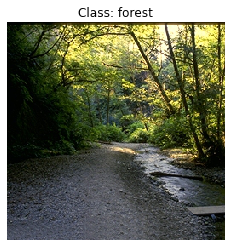

In [9]:
positions, descriptors = dsift(im, size=5, step=10)
print(positions.shape, descriptors.shape)

showImage(train_small, 0)

# Domanda 2

The size of each patch is 4x5=20px. The sampling step is 10px, so we should have an overlap of 10 px. The size of the descriptors is not the same as before beacause the number of patches has changed

# Plotting the descriptors (WEIGHTED HISTOGRAMS)

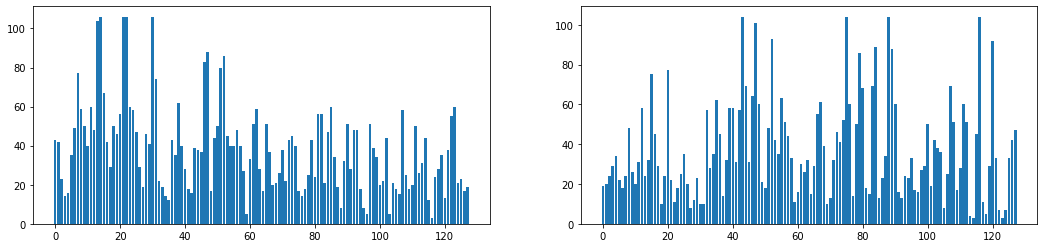

In [10]:
np.random.seed(16)

idx1,idx2 = np.random.choice(len(descriptors), 2) #prendi un descriptor casuale e dammi due valori
d1 = descriptors[idx1]
d2 = descriptors[idx2]

plt.figure(figsize=(18,4))
plt.subplot(121) #un grafico 1x2 e vai a posizionarti nel primo grafico 
plt.bar(range(len(d1)), d1) #dammi da 0 a 127 e con d1 indichiami l'altezza della barra
plt.subplot(122)
plt.bar(range(len(d2)),d2)
plt.show()

# Domanda 3

We have got 128 bars in each plot, the descriptors are not similar

In [11]:
# Describe patches from different images

im0 = io.imread(train_small.iloc[0]['filename'], as_gray=True)
im1 = io.imread(train_small.iloc[1]['filename'], as_gray=True)
im2 = io.imread(train_small.iloc[2]['filename'], as_gray=True)

_, descriptors0 = dsift(im0, size=5, step=10)
_, descriptors1 = dsift(im1, size=5, step=10)
_, descriptors2 = dsift(im2, size=5, step=10)

all_descriptors = np.vstack([descriptors0, descriptors1, descriptors2])
print(all_descriptors.shape)

(1875, 128)


# Function that extract all the descriptors from all the images of the DataFrame

In [12]:
from tqdm import tqdm

def extract_and_describe(data, size=5, step=10):
    descriptors = []
    for i, row in tqdm(data.iterrows(), "Extracting/Describing Patches", total=len(data)):
        im = io.imread(row['filename'], as_gray=True)
        _, desc = dsift(im, size=size, step=step)
        descriptors.append(desc)
    return np.vstack(descriptors)

train_descriptors = extract_and_describe(train_small)
print(train_descriptors.shape)

Extracting/Describing Patches: 100%|██████████| 114/114 [00:11<00:00, 10.22it/s]

(71250, 128)


# Domanda 4

Changing both of the parameters we can face a faster/slower execution bigger/smaller number of features.


# Creating Vocabulary of Visual Words

In [13]:
#we are going to cluster all training descriptors 
#we are going to use an implementation of KMeans
from sklearn.cluster import MiniBatchKMeans
import warnings

warnings.filterwarnings("ignore")

kmeans = MiniBatchKMeans(500) #using a vocabulary of 500 elements

kmeans.fit(train_descriptors)

#we can access to the cluster centroids as so
kmeans.cluster_centers_.shape

(500, 128)

# Domanda 5

Yes, if we insert more visual words the k-mean process is slower because we need to analyze and process more images.

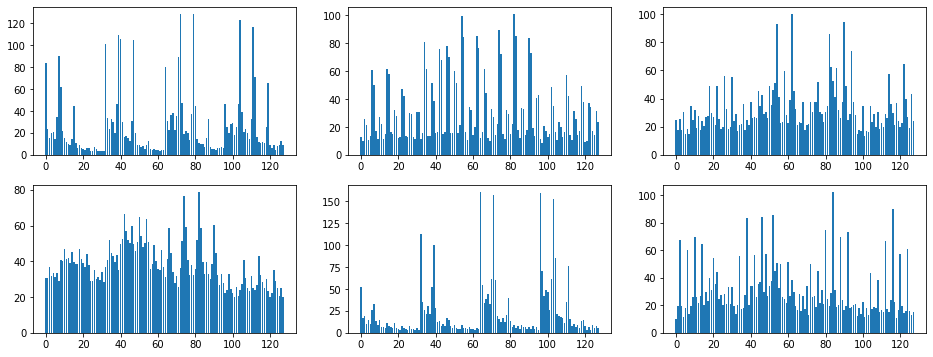

In [14]:
#choose 6 images and plot them

np.random.seed(135)
centers = np.random.permutation(kmeans.cluster_centers_)
plt.figure(figsize=(16,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(range(len(centers[i])),centers[i])
    
plt.show()

In [15]:
#associate a new descriptor to the corrisponing cluster
kmeans.predict([train_descriptors[0]])

array([151], dtype=int32)

# Domanda 6

The corrisponding cluster is choosen evaluating the minor difference from all the other sift descriptors in the database

In [16]:
#Extracting tokens for bovw representation

def load_and_describe(filename, size=5,step=10, kmeans=kmeans):
    im = io.imread(filename,as_gray=True)
    _,descriptors = dsift(im, size=size, step=step)
    tokens = kmeans.predict(descriptors)
    return tokens

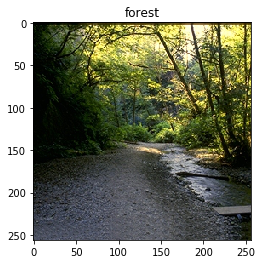

array([151, 380, 325, 271, 271, 225, 271, 271, 460, 460,  45, 325, 325,
       325, 460, 270, 498, 281, 479, 498, 479, 479, 479, 206, 479, 114,
       306,  98, 127, 404,  98, 127, 127, 404,  19, 267, 181, 181, 181,
       319, 417, 296, 150, 388, 493, 150, 260, 429, 214, 263], dtype=int32)

In [17]:
im0_path = train_small.iloc[0]['filename']
im0_class = train_small.iloc[0]['class']
im = io.imread(im0_path)

plt.imshow(im)
plt.title(im0_class)
plt.show()

tokens = load_and_describe(im0_path)
tokens[:50]

In [18]:
#counting the number of instances of each token
bovw_representation, _ = np.histogram(tokens, bins=500, range=(0,499), normed=True)

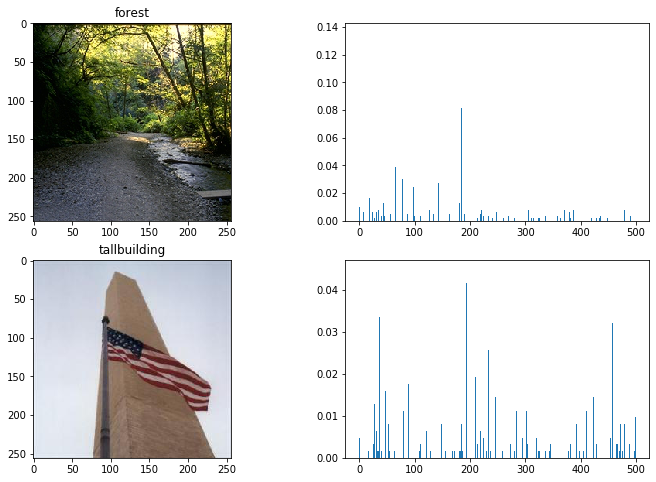

In [19]:
im1_path = train_small.iloc[1]['filename']
im1_class = train_small.iloc[1]['class']
im1 = io.imread(im1_path)
tokens1 = load_and_describe(im1_path)
bovw_representation1, _ = np.histogram(tokens1, bins=500, range=(0,499), normed=True)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(im)
plt.title(im0_class)
plt.subplot(222)
plt.bar(range(len(bovw_representation)), bovw_representation)

plt.subplot(223)
plt.imshow(im1)
plt.title(im1_class)
plt.subplot(224)
plt.bar(range(len(bovw_representation1)),bovw_representation1)
plt.show()

# Domanda 7

The two representation are not very similar. If we had picked two similar images the representations should be very similar.

In [20]:
#We can utilize a CountVectorizer object to obtain visual words count.
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(tokenizer=load_and_describe, vocabulary=range(500))
count_vect.fit(train_small['filename'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function load_and_describe at 0x7f9ca5241c20>,
                vocabulary=range(0, 500))

In [21]:
#using tfidf for the representation
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=False,norm='l1')
word_count = count_vect.transform(train_small['filename'])
tfidf.fit(word_count)

TfidfTransformer(norm='l1', smooth_idf=True, sublinear_tf=False, use_idf=False)

In [22]:
#count vectorization and normalization can be performed in one step
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=load_and_describe, vocabulary=range(500),use_idf=True)
tfidf.fit_transform(train_small['filename'])

<114x500 sparse matrix of type '<class 'numpy.float64'>'
	with 19212 stored elements in Compressed Sparse Row format>

In [23]:
x_train = tfidf.transform(train_small['filename'])
x_test = tfidf.transform(test_small['filename'])

y_train = train_small['class']
y_test = test_small['class']

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(x_train.shape)

(114, 500)


In [25]:
from sklearn.metrics import accuracy_score

print(f"Training accuracy: {accuracy_score(y_train, y_train_pred):0.2f}")
print(f"Testing accuracy : {accuracy_score(y_test, y_test_pred):0.2f}")

Training accuracy: 0.92
Testing accuracy : 0.76


# CBIR

In [26]:
#we will use KDTree for optimal indexing
from sklearn.neighbors import KDTree

tree = KDTree(x_train.todense())

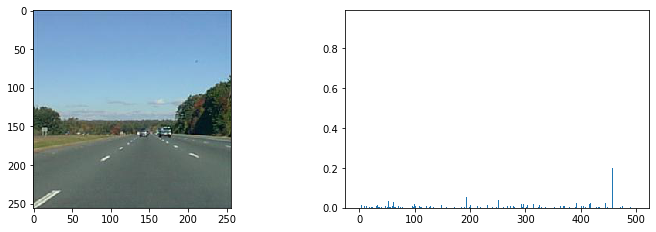

In [27]:
query_id = 0
query_im = io.imread(test_small.iloc[query_id]['filename'])
query_features = np.array(x_test.todense()[query_id])
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(query_im)
plt.subplot(222)
plt.bar(range(query_features.shape[1]),query_features[0])
plt.show()

In [28]:
#find most similar image

distance, index = tree.query(query_features)
print(distance, index)

[[0.42973339]] [[113]]


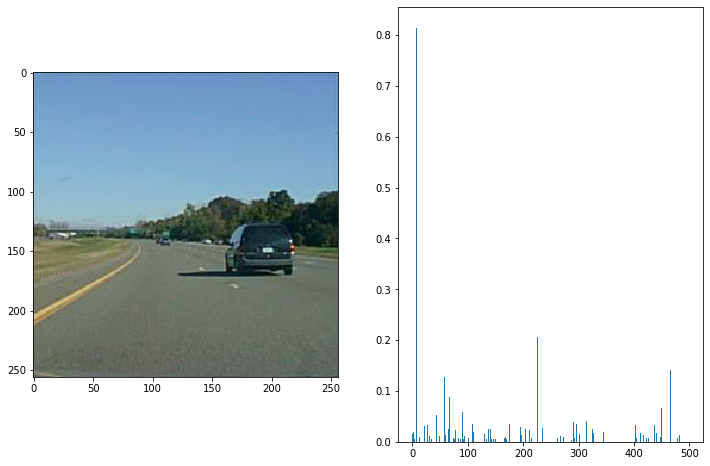

In [29]:
#load this image

index = index[0][0]
matched_im = io.imread(train_small.iloc[index]['filename'])
matched_features = np.array(x_train.todense()[index])
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(matched_im)
plt.subplot(122)
plt.bar(range(matched_features.shape[1]),matched_features[0])
plt.show()

# Domanda 8

The images are very similar but their representation are not very similar.

In [30]:
#get the k closest images

tree.query(query_features, k=3)

(array([[0.42973339, 0.88408134, 0.9465852 ]]), array([[113,  24,  75]]))

In [32]:
train_small.iloc[113]['filename']

'scenes/highway_bost162.jpg'

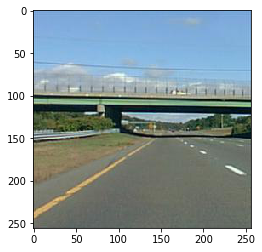

In [33]:
im24=io.imread(train_small.iloc[24]['filename'])
plt.imshow(im24)